# Exercise 8: Anomaly Detection and Recommender Systems

# 1. Anomaly detection
You suspect that the vast majority of these examples are normal (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

Gaussian model is used to detect anomalous examples in your dataset. There will be values with very low probability after being fitted to Gaussian distribution, these data can be considered as anomalies

In [126]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd

from pandas import DataFrame as df

In [127]:
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

## 1.1 Gaussian distribution
The Gaussian distribution is given by
$$p(x; \mu; \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{{(x-\mu)}^2}{2\sigma^2}}$$

In [128]:
# ================== Part 1: Load Example Dataset  ===================
# Our example case consists of 2 network server statistics across
# several machines: the latency and throughput of each machine.
# This exercise will help us find possibly faulty (or very fast) machines.

In [129]:
data1 = sio.loadmat('ex8data1.mat')

In [130]:
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [131]:
# Store values to respective variables
X = data1['X']
Xval = data1['Xval']
yval = data1['yval']

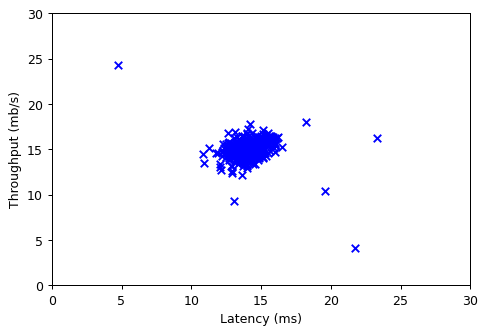

In [132]:
# Visualize the example dataset
plt.figure(dpi=90)
plt.scatter(X[:, 0], X[:, 1], marker='x', c='b')
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## 1.2 Estimating parameters for a Gaussian
To estimate the parameters $(\mu_i, \sigma^2_i)$, of $i$-th feature, The following equations can be used.  

To estimate the mean:
$$\mu_i = \frac{1}{m}\sum_{j=1}^{m}x_i^{(j)}$$

and for the variance:
$$\sigma_i^2 = \frac1m\sum_{j=1}^m(x_i^{(j)} - \mu_i)^2$$

In [133]:
# ================== Part 2: Estimate the dataset statistics ===================
#  We first estimate the parameters of our assumed Gaussian distribution, 
#  then compute the probabilities for each of the points and then visualize 
#  both the overall distribution and where each of the points falls in 
#  terms of that distribution.

In [134]:
def estimateGaussian(X):
    '''
    ESTIMATEGAUSSIAN This function estimates the parameters of a 
    Gaussian distribution using the data in X
       [mu sigma2] = estimateGaussian(X), 
       The input X is the dataset with each n-dimensional data point in one row
       The output is an n-dimensional vector mu, the mean of the data set
       and the variances sigma^2, an n x 1 vector
    '''
    # Number of dataset and features
    m, n = X.shape
    
    # Mean estimation
    mu = X.mean(axis=0)
    
    # Variance
    sigma = X.var(axis=0)
    
    return mu, sigma

In [135]:
def multivariateGaussian(X, mu, Sigma2):
    '''
    MULTIVARIATEGAUSSIAN Computes the probability density function of the
    multivariate gaussian distribution.
        p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
        density function of the examples X under the multivariate gaussian 
        distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
        treated as the covariance matrix. If Sigma2 is a vector, it is treated
        as the \sigma^2 values of the variances in each dimension (a diagonal
        covariance matrix)
    '''
    
    k = len(mu)
    
    # Check whether Sigma2 is a matrix or a vector
    if Sigma2.shape[0] or Sigma2.shape[1] == 1:
        Sigma2 = np.diag(Sigma2)
        
    X = X - mu
    
    # Probability density of multivariate gaussian distribution
    p = (2*np.pi)**(-k/2) * np.linalg.det(Sigma2)**(-0.5) * np.exp(-0.5 * np.sum((X @ np.linalg.pinv(Sigma2) * X), 1))    
    
    return p

In [136]:
def visualizeFit(X, mu, sigma2):
    '''
    VISUALIZEFIT Visualize the dataset and its estimated distribution.
       VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
       probability density function of the Gaussian distribution. Each example
       has a location (x1, x2) that depends on its feature values.
    '''
    # Estimate my and sigma2
    mu, sigma2 = estimateGaussian(X)    

    # Returns the density of the multivariate normal at each data point (row) of X
    p = multivariateGaussian(X, mu, sigma2)

    # Creating meshgrid
    X1, X2 = np.meshgrid(np.arange(0, 35.1, 0.5), np.arange(0, 35.1, 0.5))
    mesh = np.array([X1.ravel(order='F'), X2.ravel(order='F')]).T

    # Probability density of meshgrid
    Z = multivariateGaussian(mesh, mu, sigma2)
    Z = Z.reshape(X1.shape)

    # Do not plot if there are inf values
    if np.sum(np.isinf(Z)) == 0:
        plt.figure(dpi=90)
        plt.scatter(X[:, 0], X[:, 1], marker='x', c='b', lw=0.8)
        plt.contour(X1, X2, Z, 10**np.arange(-20, 0, 3, dtype=np.float))

In [137]:
# Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

In [138]:
# Returns the density of the multivariate normal at each data point (row) of X
p = multivariateGaussian(X, mu, sigma2)

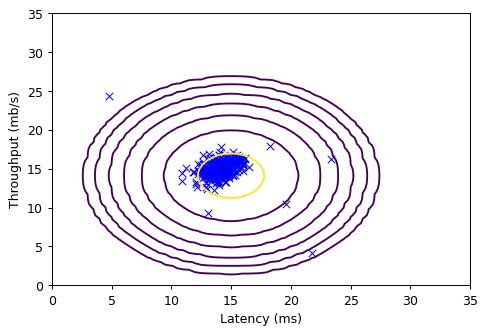

In [139]:
visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## 1.3 Selecting the threshold
This section will calculate the F1 score, which is a measure on how well the ground truth anomalies are given certain threshold. For different values of $\epsilon$ you will compute the resulting $F1$ by computing how many examples the current threshold classifies correctly and incorrectly  

F1 is computed using precision (*prec*) and recall (*rec*):  
$$F1 = \frac{2 \cdot prec \cdot rec}{prec + rec}$$

You compute precision and recall by:
$$prec = \frac{tp}{tp+fp}$$

$$rec = \frac{tp}{tp+fn}$$

where:
* $tp$ is number of true positives: ground truth label says **anomaly**, our algorithm classified as **anomaly**
* $fp$ is number of false positives: ground truth label says **not anomaly**, our algorithm classified as **anomaly**
* $fn$ is number of true positives: ground truth label says **anomaly**, our algorithm classified as **not anomaly**

In [140]:
# ================== Part 3: Find Outliers ===================
# Now you will find a good epsilon threshold using a cross-validation set 
# probabilities given the estimated Gaussian distribution

In [162]:
def selectThreshold(yval, pval):
    #SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting outliers
    #     bestEpsilon, bestF1 = SELECTTHRESHOLD(yval, pval) finds the best
    #     threshold to use for selecting outliers based on the results from a
    #     validation set (pval) and the ground truth (yval).
    
    bestF1 = 0

    stepsize = (max(pval) - min(pval))/1000

    epsilon = np.arange(min(pval), max(pval), stepsize)
    
    for e in epsilon:
        predictions = pval < e
        
        tp = np.sum(predictions[yval.ravel()==1]==1)
        fp = np.sum(predictions[yval.ravel()==0]==1)
        fn = np.sum(predictions[yval.ravel()==1]==0)   
        
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        F1 = 2* prec* rec/ (prec + rec) 
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = e
            
    return bestEpsilon, bestF1

In [142]:
pval = multivariateGaussian(Xval, mu, sigma2)

In [143]:
epsilon, F1 = selectThreshold(yval, pval)

In [144]:
epsilon

8.990852779269495e-05

In [145]:
F1

0.8750000000000001

In [146]:
print('Best epsilon found using cross-validation: %e' %epsilon)
print('Best F1 on Cross Validation Set:  %f\n' %F1)
print('(you should see a value epsilon of about 8.99e-05)')
print('(you should see a Best F1 value of  0.875000)')

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000

(you should see a value epsilon of about 8.99e-05)
(you should see a Best F1 value of  0.875000)


In [147]:
p.shape

(307,)

In [148]:
epsilon.shape

()

In [149]:
# Find the outliers in the training set and plot the
outliers = (p < epsilon)

In [150]:
X.shape

(307, 2)

In [151]:
outliers.shape

(307,)

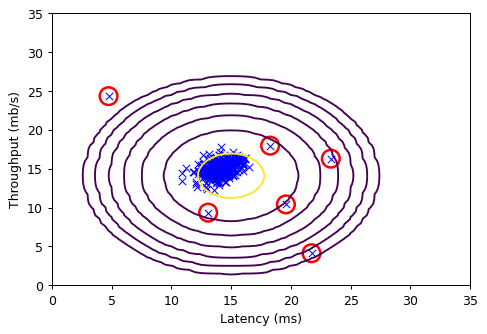

In [152]:
# Draw a red circle around those outliers
visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.scatter(X[outliers, 0], X[outliers, 1], marker='o', facecolor='none', edgecolor='r', lw=2, s=200);
plt.show()

In [153]:
# ================== Part 4: Multidimensional Outliers ===================
# We will now use the code from the previous part and apply it to a 
# harder problem in which more features describe each datapoint and only 
# some features indicate whether a point is an outlier.

In [154]:
# Load the second dataset
data2 = sio.loadmat('ex8data2.mat')

In [155]:
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [156]:
# Store values to respective variables
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']

In [157]:
# Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

In [158]:
# Training set
p = multivariateGaussian(X, mu, sigma2)

In [159]:
# Cross-validation set
pval =  multivariateGaussian(Xval, mu, sigma2)

In [160]:
# Find the best threshold
epsilon, F1 = selectThreshold(yval, pval);

In [161]:
print('Best epsilon found using cross-validation: %e' %epsilon);
print('Best F1 on Cross Validation Set:  %f\n' %F1);
print('(you should see a value epsilon of about 1.38e-18)');
print('(you should see a Best F1 value of 0.615385)');
print('# Outliers found: %d' %sum(p < epsilon));

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385

(you should see a value epsilon of about 1.38e-18)
(you should see a Best F1 value of 0.615385)
# Outliers found: 117
